In [4]:
%matplotlib inline

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

/Users/Tako/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Tako/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [5]:
train_housing = pd.read_csv("train.csv")
test_housing = pd.read_csv("test.csv")

In [263]:
train_housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [264]:
print train_housing.shape

(1460, 81)


In [266]:
test_housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [267]:
print test_housing.shape

(1459, 80)


In [268]:
train_housing.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [269]:
train_housing.dtypes.head()

Id               int64
MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
dtype: object

In [8]:
null_vals = train_housing.apply(lambda col: col.isnull()).sum()
null_vals[null_vals != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [9]:
train_housing['Electrical'][train_housing['Electrical'].isnull()]

1379    NaN
Name: Electrical, dtype: object

In [10]:
train_housing.apply(lambda col: col.isnull()).mean().value_counts()

0.000000    62
0.055479     5
0.025342     3
0.005479     2
0.026027     2
0.472603     1
0.807534     1
0.995205     1
0.177397     1
0.000685     1
0.937671     1
0.963014     1
dtype: int64

In [63]:
null_vals[null_vals > len(train_housing)/2].index

Index([u'Alley', u'PoolQC', u'Fence', u'MiscFeature'], dtype='object')

In [54]:
# Drop columns that are more than half empty 
train_housing_trimmed = train_housing.drop(null_vals[null_vals > len(train_housing)/2].index,1)

In [60]:
train_data, train_price = train_housing_trimmed.loc[:,'Id':'SaleCondition'], train_housing_trimmed['SalePrice']

In [61]:
test_data = test_housing.drop(null_vals[null_vals > len(train_housing)/2].index,1)
test_data = test_housing

In [62]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,129959.938379
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,157603.704358
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,193021.983693
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,213160.608923
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,197973.047238


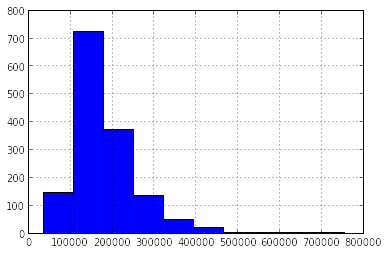

In [211]:
train_price.hist()

In [161]:
X = pd.DataFrame(train_price.values.reshape(-1, 1))

from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
km.fit(X)
km.cluster_centers_

array([[ 147134.05777778],
       [ 294385.46567164]])

In [84]:
labels = km.predict(X)
labels

array([0, 0, 1, ..., 1, 0, 0], dtype=int32)

In [85]:
dists = km.transform(X)
dists

array([[  61365.94222222,   85885.46567164],
       [  34365.94222222,  112885.46567164],
       [  76365.94222222,   70885.46567164],
       ..., 
       [ 119365.94222222,   27885.46567164],
       [   5009.05777778,  152260.46567164],
       [    365.94222222,  146885.46567164]])

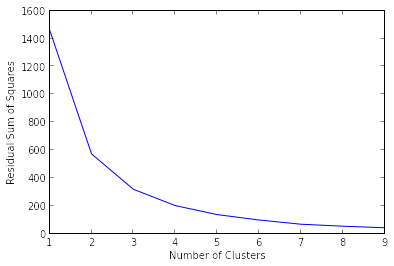

In [86]:
clusts = range(1, 10)

def kmean_rss_score(nclust):
    km = Pipeline([('scale', StandardScaler()), ('cluster', KMeans(nclust))])
    km.fit(X)
    rss = -km.score(X)
    return rss

rss = [kmean_rss_score(i) for i in clusts]
plt.plot(clusts, rss)
plt.xlabel('Number of Clusters')
plt.ylabel('Residual Sum of Squares')
plt.show()

In [64]:
# Separate predictors into numeric and categorical groups
numeric_predictors = [
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'WoodDeckSF',
    'LotArea', 'ScreenPorch', 'MiscVal', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea',
    'LowQualFinSF', 'OpenPorchSF', 'PoolArea', 'TotRmsAbvGrd',
    'LotFrontage', 'MasVnrArea', 'MasVnrArea' # COLUMNS WITH NULL VALUES
]
categorical_predictors = train_data.columns.difference(numeric_predictors)

In [16]:
(train_data).apply(lambda col: col == 0).sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage         0
LotArea             0
Street              0
Alley               0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          0
MasVnrArea        861
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
HalfBath          913
BedroomAbvGr        6
KitchenAbvGr        1
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces        690
FireplaceQu         0
GarageType          0
GarageYrBlt         0
GarageFinish        0
GarageCars         81
GarageArea         81
GarageQual          0
GarageCond

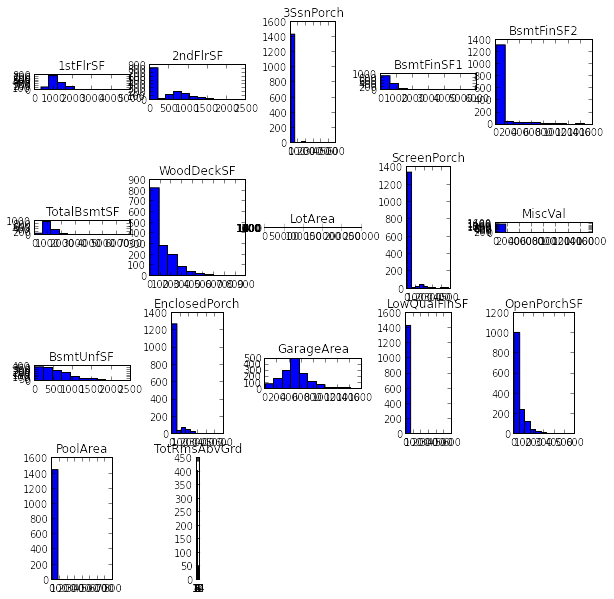

In [279]:
# Initialize plt
fig = plt.figure(figsize=(10, 10))

# Initialize count
count = 1

# Plot the figures
for numeric_predictor in numeric_predictors:
    ax = fig.add_subplot(4, 5, count, adjustable='box', aspect='equal')
    ax.hist(train_data[numeric_predictor])
    ax.set_title(numeric_predictor)
    count = count +1

In [195]:
train_data[categorical_predictors].head().T

,0,1,2,3,4
BedroomAbvGr,3,3,3,3,4
BldgType,1Fam,1Fam,1Fam,1Fam,1Fam
BsmtFullBath,1,0,1,1,1
BsmtHalfBath,0,1,0,0,0
CentralAir,Y,Y,Y,Y,Y
Condition1,Norm,Feedr,Norm,Norm,Norm
Condition2,Norm,Norm,Norm,Norm,Norm
Electrical,SBrkr,SBrkr,SBrkr,SBrkr,SBrkr
ExterCond,TA,TA,TA,TA,TA
ExterQual,Gd,TA,Gd,TA,Gd


In [17]:
# Instantiate modules required for numeric predictors

def select_numeric_features(X):
    return X[numeric_predictors]

# Instantiate necessary modules
numeric_selector = FunctionTransformer(select_numeric_features, validate=False)
imp = Imputer(strategy='mean')
ss = StandardScaler()

# Instantiate modules required for categorical predictors

def select_categorical_features(X):
    return X[categorical_predictors]

scf = FunctionTransformer(select_categorical_features, validate=False)

def ensure_datatype(X):
    return X.apply(lambda col: col.astype(str))

ed = FunctionTransformer(ensure_datatype, validate=False)

from sklearn.feature_extraction import DictVectorizer

def make_dictionaries(X):
    return X.to_dict(orient='records')

md = FunctionTransformer(make_dictionaries, validate=False)

In [18]:
numeric_feature_pipeline = Pipeline(steps=[
    ('select', FunctionTransformer(select_numeric_features, validate=False)),
    ('impute', Imputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('select', FunctionTransformer(select_categorical_features, validate=False)),
    ('datatype', FunctionTransformer(ensure_datatype, validate=False)),
    ('dictionaries', FunctionTransformer(make_dictionaries, validate=False)),
    ('vectorize', FeatureHasher())
])

fu = FeatureUnion([
    ('categorical', categorical_pipeline), 
    ('numeric', numeric_feature_pipeline)
])

fr = Pipeline([
    ('union', fu),
    ('reduction', TruncatedSVD())
])

In [65]:
search_params = {
    'preprocess__reduction__n_components': [10, 20, 50, 100, 200, 500, 1000],
    'preprocess__union__categorical__vectorize__n_features': [1000, 2000, 5000],
    'preprocess__union__numeric__impute__strategy': ['mean', 'median', 'most_frequent'],
    'predict__alpha': [1, 10, 50, 100, 200, 500]
}

In [66]:
model_pipe_ridge = Pipeline(steps=[
    ('preprocess', fr),
    ('predict', Ridge(alpha=100))
])

In [67]:
grid_search = GridSearchCV(model_pipe_ridge, search_params, cv=5)
clf_ridge = grid_search.fit(train_data, np.log(train_price))
grid_search.best_params_

{'predict__alpha': 10,
 'preprocess__reduction__n_components': 1000,
 'preprocess__union__categorical__vectorize__n_features': 5000,
 'preprocess__union__numeric__impute__strategy': 'most_frequent'}

In [68]:
prices = np.exp(clf_ridge.predict(test_data))

In [69]:
test_data['SalePrice'] = prices
columns_submission = ['Id', 'SalePrice']
test_data.to_csv('tako_hisada_submission_20180401_ridge_04.csv', columns=columns_submission, index=False)

In [312]:
model_pipe_lasso = Pipeline(steps=[
    ('preprocess', fu),
    ('predict', Lasso(alpha=100))
])

In [313]:
grid_search = GridSearchCV(model_pipe_lasso, search_params, cv=5)
clf_lasso = grid_search.fit(train_data, np.log(train_price))
grid_search.best_params_

{'predict__alpha': 1,
 'preprocess__categorical__vectorize__n_features': 5,
 'preprocess__numeric__impute__strategy': 'mean'}

In [314]:
prices = np.exp(clf_lasso.predict(test_data))

In [315]:
test_data['SalePrice'] = prices
columns_submission = ['Id', 'SalePrice']

In [316]:
test_data.to_csv('tako_hisada_submission_20180330_lasso_02.csv', columns=columns_submission, index=False)

In [317]:
model_pipe_logistic_regression = Pipeline(steps=[
    ('preprocess', fu),
    ('predict', LogisticRegression())
])

In [318]:
search_params_lr = {
    #'preprocess__reduction__n_components': [2, 3, 4, 5, 10, 20],
    'preprocess__categorical__vectorize__n_features': [5, 15, 75, 100, 200],
    'preprocess__numeric__impute__strategy': ['mean', 'median', 'most_frequent'],
    'predict__C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 100, 1000, 1e18]
}

In [ ]:
grid_search = GridSearchCV(model_pipe_logistic_regression, search_params_lr, cv=5)
clf_lr = grid_search.fit(train_data, train_price)
grid_search.best_params_

In [70]:
prices = clf_lr.predict(test_data)

In [71]:
test_data['SalePrice'] = prices
columns_submission = ['Id', 'SalePrice']
test_data.to_csv('tako_hisada_submission_20180327_logistic-regression_02.csv', columns=columns_submission, index=False)